In [1]:
import transform
import imutils
from scipy.spatial import distance as dist
from matplotlib.patches import Polygon
import polygon_interacter as poly_i
import numpy as np
import matplotlib.pyplot as plt
import itertools
import math
import cv2
import os
import timeit

In [2]:
MIN_QUAD_AREA_RATIO=0.25
MAX_QUAD_ANGLE_RANGE=40

In [3]:
def filter_corners(corners, min_dist=20):
        def predicate(representatives, corner):
            return all(dist.euclidean(representative, corner) >= min_dist
                       for representative in representatives)

        filtered_corners = []
        for c in corners:
            if predicate(filtered_corners, c):
                filtered_corners.append(c)
        return filtered_corners

In [4]:
def angle_between_vectors_degrees(u, v):
        return np.degrees(
            math.acos(np.dot(u, v) / (np.linalg.norm(u) * np.linalg.norm(v))))

In [5]:
def get_angle(p1, p2, p3):

        a = np.radians(np.array(p1))
        b = np.radians(np.array(p2))
        c = np.radians(np.array(p3))

        avec = a - b
        cvec = c - b

        return angle_between_vectors_degrees(avec, cvec)

In [6]:
def angle_range(quad):

        tl, tr, br, bl = quad
        ura = get_angle(tl[0], tr[0], br[0])
        ula = get_angle(bl[0], tl[0], tr[0])
        lra = get_angle(tr[0], br[0], bl[0])
        lla = get_angle(br[0], bl[0], tl[0])

        angles = [ura, ula, lra, lla]
        return np.ptp(angles)

In [7]:
def get_corners(img):

        lsd = cv2.createLineSegmentDetector()
        lines = lsd.detect(img)[0]
        corners = []
        
        if lines is not None:
            lines = lines.squeeze().astype(np.int32).tolist()
            horizontal_lines_canvas = np.zeros(img.shape, dtype=np.uint8)
            vertical_lines_canvas = np.zeros(img.shape, dtype=np.uint8)
            for line in lines:
                x1, y1, x2, y2 = line
                if abs(x2 - x1) > abs(y2 - y1):
                    (x1, y1), (x2, y2) = sorted(((x1, y1), (x2, y2)), key=lambda pt: pt[0])
                    cv2.line(horizontal_lines_canvas, (max(x1 - 5, 0), y1), (min(x2 + 5, img.shape[1] - 1), y2), 255, 2)
                else:
                    (x1, y1), (x2, y2) = sorted(((x1, y1), (x2, y2)), key=lambda pt: pt[1])
                    cv2.line(vertical_lines_canvas, (x1, max(y1 - 5, 0)), (x2, min(y2 + 5, img.shape[0] - 1)), 255, 2)

            lines = []

            contours = cv2.findContours(horizontal_lines_canvas, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
            contours = contours[1]
            contours = sorted(contours, key=lambda c: cv2.arcLength(c, True), reverse=True)[:2]
            horizontal_lines_canvas = np.zeros(img.shape, dtype=np.uint8)
            
            for contour in contours:
                contour = contour.reshape((contour.shape[0], contour.shape[2]))
                min_x = np.amin(contour[:, 0], axis=0) + 2
                max_x = np.amax(contour[:, 0], axis=0) - 2
                left_y = int(np.average(contour[contour[:, 0] == min_x][:, 1]))
                right_y = int(np.average(contour[contour[:, 0] == max_x][:, 1]))
                lines.append((min_x, left_y, max_x, right_y))
                cv2.line(horizontal_lines_canvas, (min_x, left_y), (max_x, right_y), 1, 1)
                corners.append((min_x, left_y))
                corners.append((max_x, right_y))

            contours = cv2.findContours(vertical_lines_canvas, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
            contours = contours[1]
            contours = sorted(contours, key=lambda c: cv2.arcLength(c, True), reverse=True)[:2]
            vertical_lines_canvas = np.zeros(img.shape, dtype=np.uint8)
            
            for contour in contours:
                contour = contour.reshape((contour.shape[0], contour.shape[2]))
                min_y = np.amin(contour[:, 1], axis=0) + 2
                max_y = np.amax(contour[:, 1], axis=0) - 2
                top_x = int(np.average(contour[contour[:, 1] == min_y][:, 0]))
                bottom_x = int(np.average(contour[contour[:, 1] == max_y][:, 0]))
                lines.append((top_x, min_y, bottom_x, max_y))
                cv2.line(vertical_lines_canvas, (top_x, min_y), (bottom_x, max_y), 1, 1)
                corners.append((top_x, min_y))
                corners.append((bottom_x, max_y))

            corners_y, corners_x = np.where(horizontal_lines_canvas + vertical_lines_canvas == 2)
            corners += zip(corners_x, corners_y)

        corners = filter_corners(corners)
        return corners

In [8]:
def is_valid_contour(cnt, IM_WIDTH, IM_HEIGHT):

        return (len(cnt) == 4 and cv2.contourArea(cnt) > IM_WIDTH * IM_HEIGHT * MIN_QUAD_AREA_RATIO 
            and angle_range(cnt) < MAX_QUAD_ANGLE_RANGE)

In [9]:
def get_contour(rescaled_image):

        MORPH = 9
        CANNY = 84
        HOUGH = 25

        IM_HEIGHT, IM_WIDTH, _ = rescaled_image.shape

        gray = cv2.cvtColor(rescaled_image, cv2.COLOR_BGR2GRAY)
        gray = cv2.GaussianBlur(gray, (7,7), 0)

        kernel = cv2.getStructuringElement(cv2.MORPH_RECT,(MORPH,MORPH))
        dilated = cv2.dilate(gray, kernel)

        edged = cv2.Canny(dilated, 0, CANNY)
        test_corners = get_corners(edged)

        approx_contours = []

        if len(test_corners) >= 4:
            quads = []

            for quad in itertools.combinations(test_corners, 4):
                points = np.array(quad)
                points = transform.order_points(points)
                points = np.array([[p] for p in points], dtype = "int32")
                quads.append(points)

            quads = sorted(quads, key=cv2.contourArea, reverse=True)[:5]
            quads = sorted(quads, key=angle_range)

            approx = quads[0]
            if is_valid_contour(approx, IM_WIDTH, IM_HEIGHT):
                approx_contours.append(approx)


        (_, cnts, hierarchy) = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        cnts = sorted(cnts, key=cv2.contourArea, reverse=True)[:5]

        for c in cnts:
            approx = cv2.approxPolyDP(c, 80, True)
            if is_valid_contour(approx, IM_WIDTH, IM_HEIGHT):
                approx_contours.append(approx)
                break

        if not approx_contours:
            TOP_RIGHT = (IM_WIDTH, 0)
            BOTTOM_RIGHT = (IM_WIDTH, IM_HEIGHT)
            BOTTOM_LEFT = (0, IM_HEIGHT)
            TOP_LEFT = (0, 0)
            screenCnt = np.array([[TOP_RIGHT], [BOTTOM_RIGHT], [BOTTOM_LEFT], [TOP_LEFT]])

        else:
            screenCnt = max(approx_contours, key=cv2.contourArea)
            
        return screenCnt.reshape(4, 2)

In [10]:
def interactive_get_contour(screenCnt, rescaled_image):
        poly = Polygon(screenCnt, animated=True, fill=False, color="blue", linewidth=5)
        fig, ax = plt.subplots()
        ax.add_patch(poly)
        ax.set_title(('Select the document and close the window when finished.'))
        p = poly_i.PolygonInteractor(ax, poly)
        plt.imshow(rescaled_image)
        plt.show()
        new_points = p.get_poly_points()[:4]
        new_points = np.array([[p] for p in new_points], dtype = "int32")
        return new_points.reshape(4, 2)

In [11]:
def scan(image):

    RESCALED_HEIGHT = 500.0
    OUTPUT_DIR = 'output'
    assert(image is not None)

    ratio = image.shape[0] / RESCALED_HEIGHT
    orig = image.copy()
    rescaled_image = imutils.resize(image, height = int(RESCALED_HEIGHT))

    screenCnt = get_contour(rescaled_image)

    screenCnt = interactive_get_contour(screenCnt, rescaled_image)

    warped = transform.four_point_transform(orig, screenCnt * ratio)

    gray = cv2.cvtColor(warped, cv2.COLOR_BGR2GRAY)

    sharpen = cv2.GaussianBlur(gray, (0,0), 3)
    sharpen = cv2.addWeighted(gray, 1.5, sharpen, -0.5, 0)

    thresh = cv2.adaptiveThreshold(sharpen, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 21, 15)
    return thresh

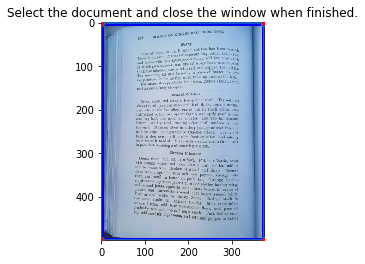

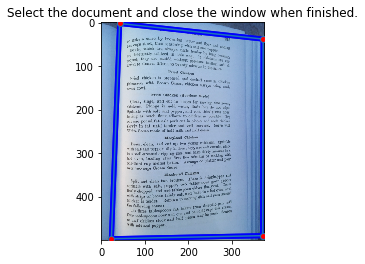

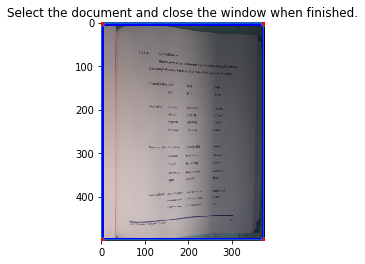

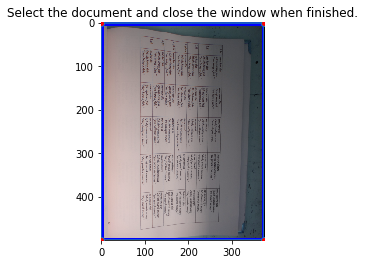

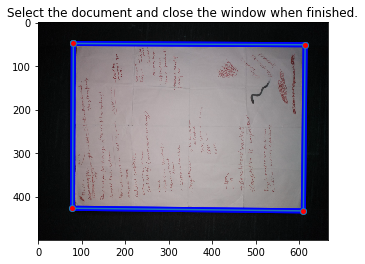

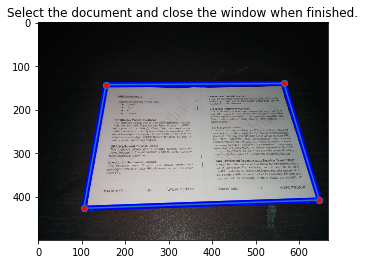

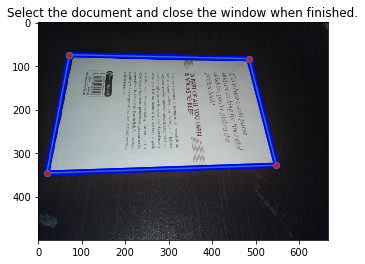

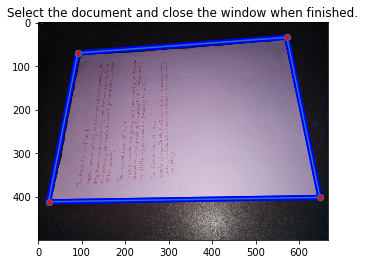

COMPLETED
Total Time:  6.519464000000001
Avg. Time per Image:  0.8149330000000001


In [12]:
if __name__ == "__main__":
    entries=os.listdir("example_input/")
    count=1
    start = timeit.default_timer()
    
    for entry in entries:
            image= cv2.imread("example_input/"+entry)
            cv2.imwrite("output/"+entry,scan(image))
            
    print("COMPLETED")
    stop = timeit.default_timer()
    print('Total Time: ', stop - start)
    print('Avg. Time per Image: ',(stop-start)/len(entries))